<H1> RF </H1> <br> 
Learn how to use scikit-rf  <br> 
<hr> 
<H2>Modification history </H2>
<table>
    <tr>
        <th> Modified </th>
        <th> BY </th>
        <th> Reason </th>
    </tr>
    <tr>
        <td> 30-Jun-24</td>
        <td> CBL </td>
        <td> Original </td>
    </tr>
</table>

<hr> 
<H2> References </H2> 
<a href = "https://scikit-rf.readthedocs.io/en/latest/tutorials/Circuit.html"> Example circuits </a><br> 
<a href = "https://onlinelibrary.wiley.com/doi/10.1002/mop.10983"> Microwave S-Parameter reduction </a>

In [18]:
# imports - package libraries etc. 
import numpy as np
import matplotlib.pyplot as plt
import math
import skrf as rf
from skrf.media import Coaxial
from timeit import timeit
#
# skrf figure styling
rf.stylely()

In [24]:
# source impedence 
Z_S   = 50  # ohms
Z_0   = 50  # 50 ohm transmission line
Z_L   = 10+5j # 100 ohm load
theta = 0   # can specify length, but here specify the angle
# create a range of frequencies, like numpy arange but has properties from scikit-rf
freq = rf.Frequency(start=1,stop=10,unit='GHz',npoints=10)

# Create all the network elements.
# imporant: all the Network must hav the parameter "name" defined
# define the source port
port1 = rf.Circuit.Port(freq, 'port1', z0=Z_S)

# define the transmission line One way to do it. 
# Z0 is characteristic impedance
# alpha - real attenuation
# beta  - imagniary attenuation
# gamma - propagation constant
# npoints - number of points on frequency axis
# v_g complex group velocity m/s
# v_p complex phase velocity m/s
# z0 Return characteristic impedence
# z0_characteristic
# z0_override - port impedance
# z0_port - port impedance
tline_media = rf.DefinedGammaZ0(freq, z0=Z_0,  gamma=1j*freq.w/rf.c)  # properties of the transmission line over the frequency set. 
trans_line  = tline_media.line(theta, unit='deg',name='trans_line')

# define the resistor at the end
load        = tline_media.resistor(Z_L, name='delay_load')
# lets redefine this as an antenna. 

# return path - ground
ground      = rf.Circuit.Ground(freq, name='ground')

# make connection list
cnx = [
    [(port1, 0), (trans_line,0)],
    [(trans_line,1),(load, 0)],
    [(load,1), (ground,0)]
]
# build the circuit
cir = rf.Circuit(cnx)

# get the resulting Network from the 'network' parameter:
ntw = cir.network
print(ntw.s)

[[[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]

 [[-0.65517241+0.13793103j]]]


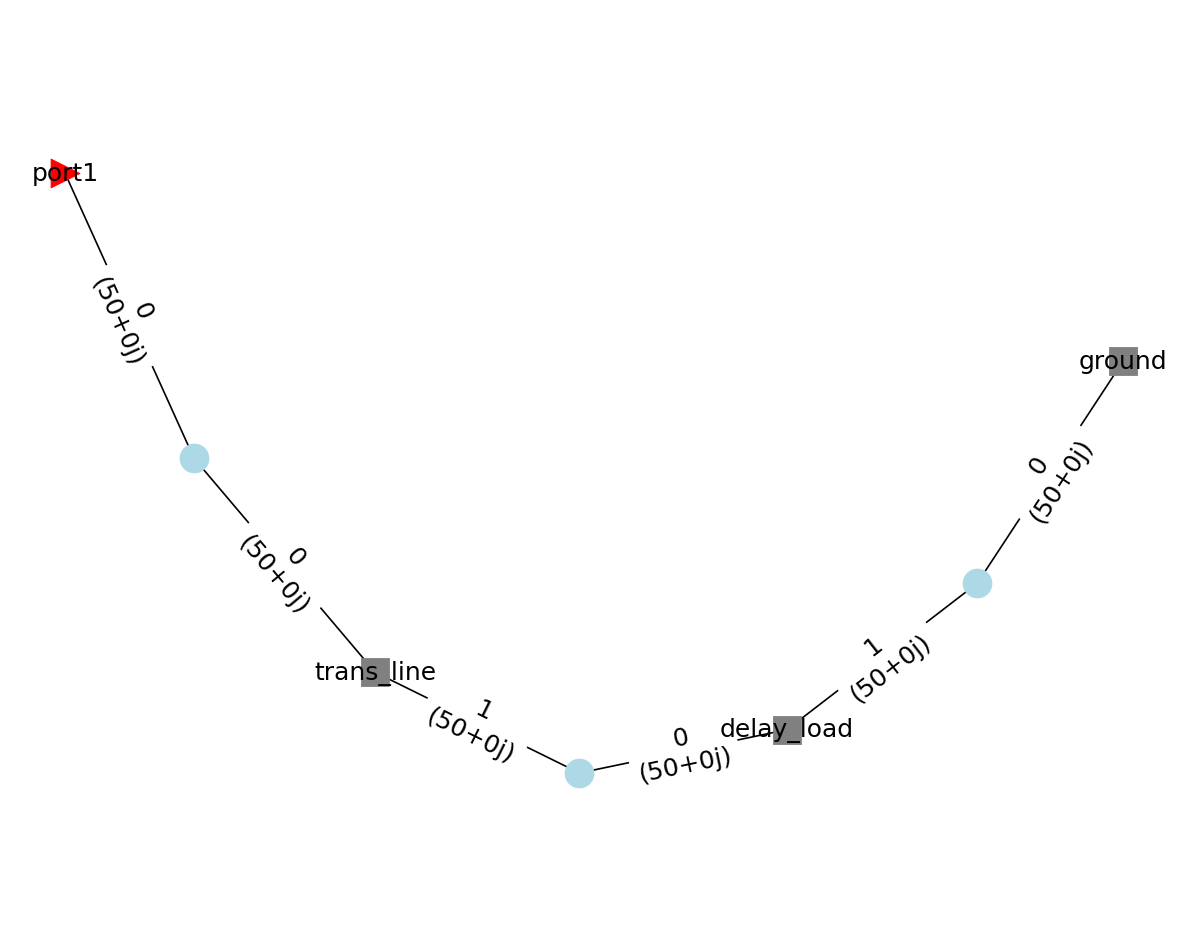

In [25]:
cir.plot_graph(network_labels=True, network_fontsize=15, 
               port_labels=True, port_fontsize=15,
               edge_labels=True, edge_fontsize=15)

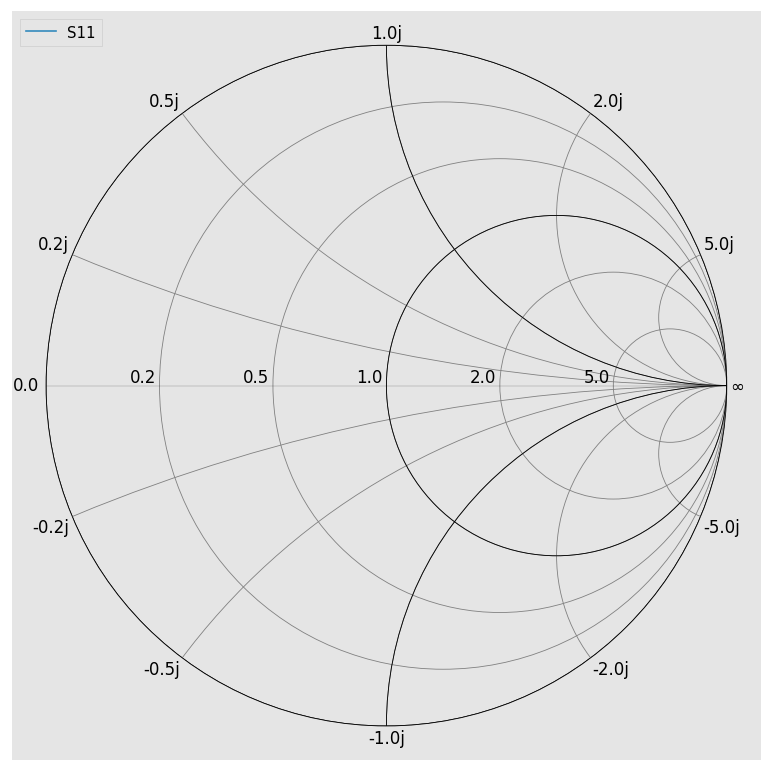

In [26]:
# Use matplot lib to make a subplot. 
fig,ax = plt.subplots(1,1,figsize=(8,8))
# add a highres background if interested. 
background = plt.imread('figures/smithchart.png')
# move the background about a bit, need to adjust. 
#ax.imshow(background, extent=[-1.185, 1.15, -1.13, 1.155])
rf.plotting.smith(ax=ax, draw_labels=True, ref_imm=1.0, chart_type='z')
ntw.plot_s_smith(ax=ax)

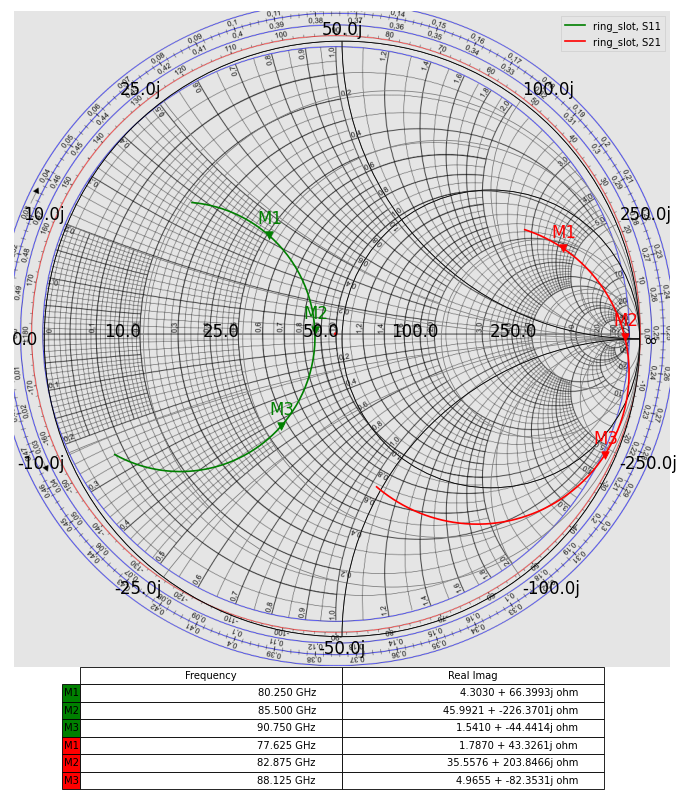

In [29]:
# The chart doesn't appear to be plotting, try this example.
# Load the data file.
ring_slot = rf.Network('data/ring_slot.s2p')
# prepare markers
lines = [
    {'marker_idx': [30, 60, 90], 'color': 'g', 'm': 0, 'n': 0, 'ntw': ring_slot},
    {'marker_idx': [15, 45, 75], 'color': 'r', 'm': 1, 'n': 0, 'ntw': ring_slot},
]

# prepare figure
fig, ax = plt.subplots(1, 1, figsize=(7,8))

# This is pre-loaded in previous cell. 
ax.imshow(background, extent=[-1.185, 1.15, -1.13, 1.155])

# impedance smith chart
rf.plotting.smith(ax = ax, draw_labels = True, ref_imm = 50.0, chart_type = 'z')

# plot data
col_labels = ['Frequency', 'Real Imag']
row_labels = []
row_colors = []
cell_text = []
for l in lines:
    m = l['m']
    n = l['n']
    l['ntw'].plot_s_smith(m=m, n=n, ax = ax, color=l['color'])
    #plot markers
    for i, k in enumerate(l['marker_idx']):
        x = l['ntw'].s.real[k, m, n]
        y = l['ntw'].s.imag[k, m, n]
        z = l['ntw'].z[k, m, n]
        z = f'{z.real:.4f} + {z.imag:.4f}j ohm'
        f = l['ntw'].frequency.f_scaled[k]
        f_unit = l['ntw'].frequency.unit
        row_labels.append(f'M{i + 1}')
        row_colors.append(l['color'])
        ax.scatter(x, y, marker = 'v', s=20, color=l['color'])
        ax.annotate(row_labels[-1], (x, y), xytext=(-7, 7), textcoords='offset points', color=l['color'])
        cell_text.append([f'{f:.3f} {f_unit}', z])
leg1 = ax.legend(loc="upper right", fontsize= 6)

# plot the table
the_table = ax.table(cellText=cell_text,
                      colWidths=[0.4] * 2,
                      rowLabels=row_labels,
                      colLabels=col_labels,
                      rowColours=row_colors,
                      loc='bottom')
the_table.auto_set_font_size(False)
the_table.set_fontsize(6)
#the_table.scale(1.5, 1.5)

<H1> Bandpass filter example <H1>

<H1> Bandpass filter example <H1>
<img src="https://scikit-rf.readthedocs.io/en/latest/_images/circuit_filter1.svg">

In [10]:
freq = rf.Frequency(start=0.1, stop=10, unit='GHz', npoints=1001)
# Z0 is characteristic impedance
# alpha - real attenuation
# beta  - imagniary attenuation
# gamma - propagation constant
# npoints - number of points on frequency axis
# v_g complex group velocity m/s
# v_p complex phase velocity m/s
# z0 Return characteristic impedence
# z0_characteristic
# z0_override - port impedance
# z0_port - port impedance
tl_media = rf.DefinedGammaZ0(freq, z0=50, gamma=1j*freq.w/rf.c)
C1 = tl_media.capacitor(3.222e-12, name='C1')
C2 = tl_media.capacitor(82.25e-15, name='C2')
C3 = tl_media.capacitor(3.222e-12, name='C3')
L2 = tl_media.inductor(8.893e-9, name='L2')
RL = tl_media.resistor(50.0, name = 'RL')
gnd = rf.Circuit.Ground(freq, name='gnd')
port1 = rf.Circuit.Port(freq, name='port1', z0=50)
port2 = rf.Circuit.Port(freq, name='port2', z0=50)
#
# create the circuit, connection diagram first. 
#
cnx = [
    [(port1,0), (C1,0), (L2,0), (C2,0)],
    [(L2,1), (C2,1), (C3,0),(port2,0)],
    [(gnd,0), (C1,1), (C3,1)],
]
cir = rf.Circuit(cnx)
ntw=cir.network

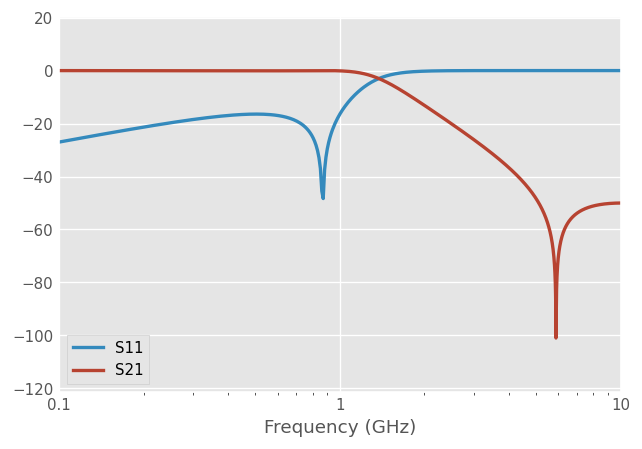

In [11]:
ntw.plot_s_db(m=0, n=0, lw=2, logx=True)
ntw.plot_s_db(m=1, n=0, lw=2, logx=True)

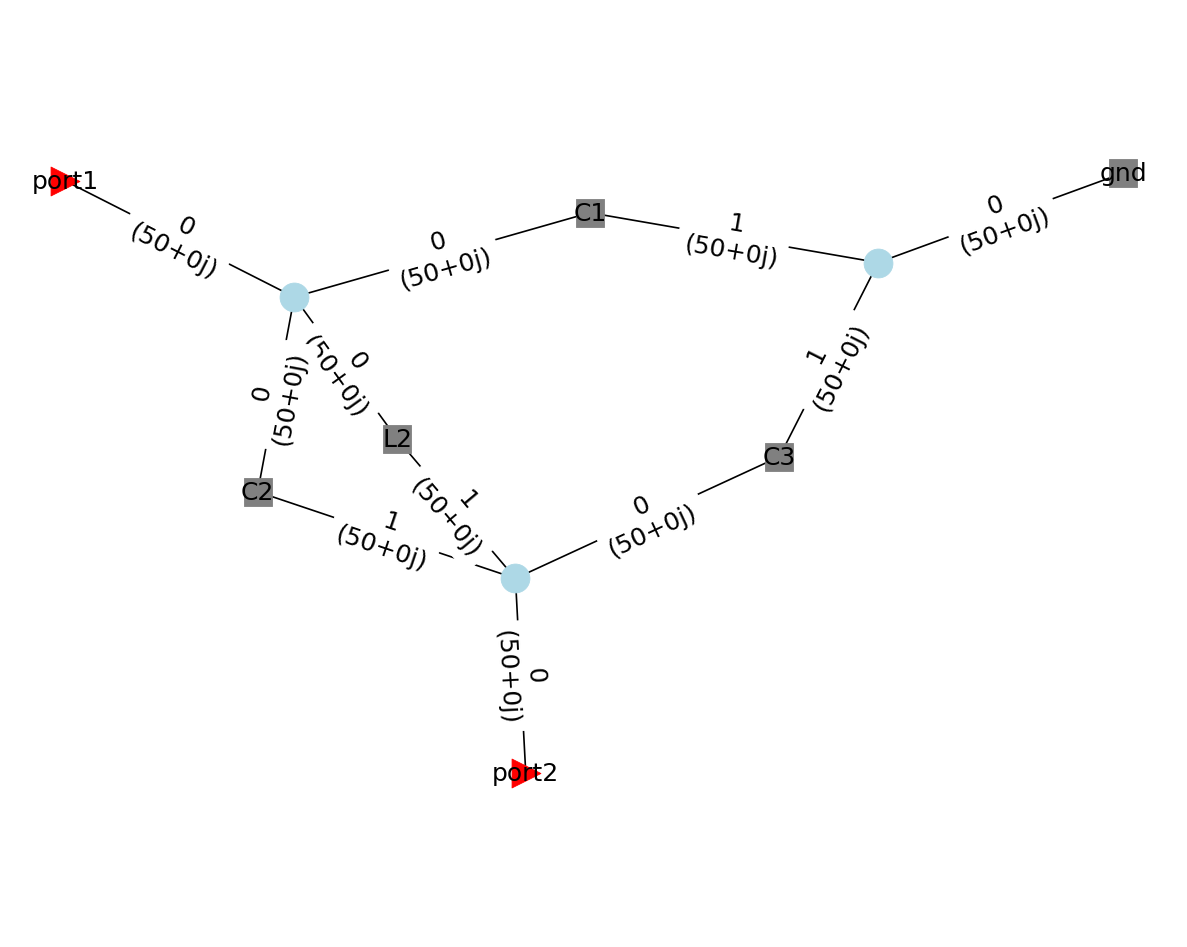

In [12]:
cir.plot_graph(network_labels=True, network_fontsize=15, 
               port_labels=True, port_fontsize=15,
               edge_labels=True, edge_fontsize=15)

Now try this one. <br> 
<img src="https://scikit-rf.readthedocs.io/en/latest/_images/circuit_filter2.svg">

In [13]:
freq = rf.Frequency(50, 200, 301, 'mhz')
tl_media = rf.media.DefinedGammaZ0(frequency=freq, z0=50)
gnd = rf.Circuit.Ground(frequency=freq,name='ground')
C1 = tl_media.capacitor(6.353e-12, name='C1')
L1 = tl_media.inductor(402.7e-9, name='L1')
C2 = tl_media.capacitor(61.08e-12, name='C2')
L2 = tl_media.inductor(13.63e-9, name='L2')
C3 = tl_media.capacitor(187.8e-12, name='C3')
L3 = tl_media.inductor(41.89e-9, name='L3')
C4 = tl_media.capacitor(6.353e-12, name='C4')
L4 = tl_media.inductor(402.27e-9, name='L4')
Port1 = rf.Circuit.Port(frequency=freq, name='PortIn')
Port2 = rf.Circuit.Port(frequency=freq, name='PortOut')
cnx = [
    [(Port1, 0), (C1, 0)],
    [(C1, 1), (L1, 0)],
    [(L1, 1), (C2, 0), (C3, 0), (C4, 0)],
    [(C2, 1), (L2, 0)],
    [(C3, 1), (L3, 0)],
    [(L2, 1), (L3, 1), (gnd, 0)],
    [(C4, 1), (L4, 0)],
    [(L4, 1), (Port2, 0)]
]
cir = rf.Circuit(cnx)
ntw = cir.network

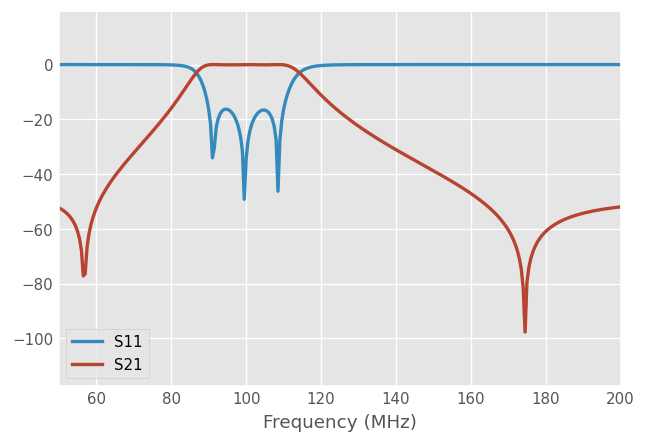

In [15]:
# m first index of s-parameter matrix
# n second index of s-parameter matrix
# ax - matplotlib axis
# show_legend = boolean
# y_label
# logx - boolean
# **kwargs - passed to matplotlib (in this case lw)
# attribute (string) eg color='r'
# conversion (string)
ntw.plot_s_db(m=0, n=0, lw=2)
ntw.plot_s_db(m=1, n=0, lw=2)

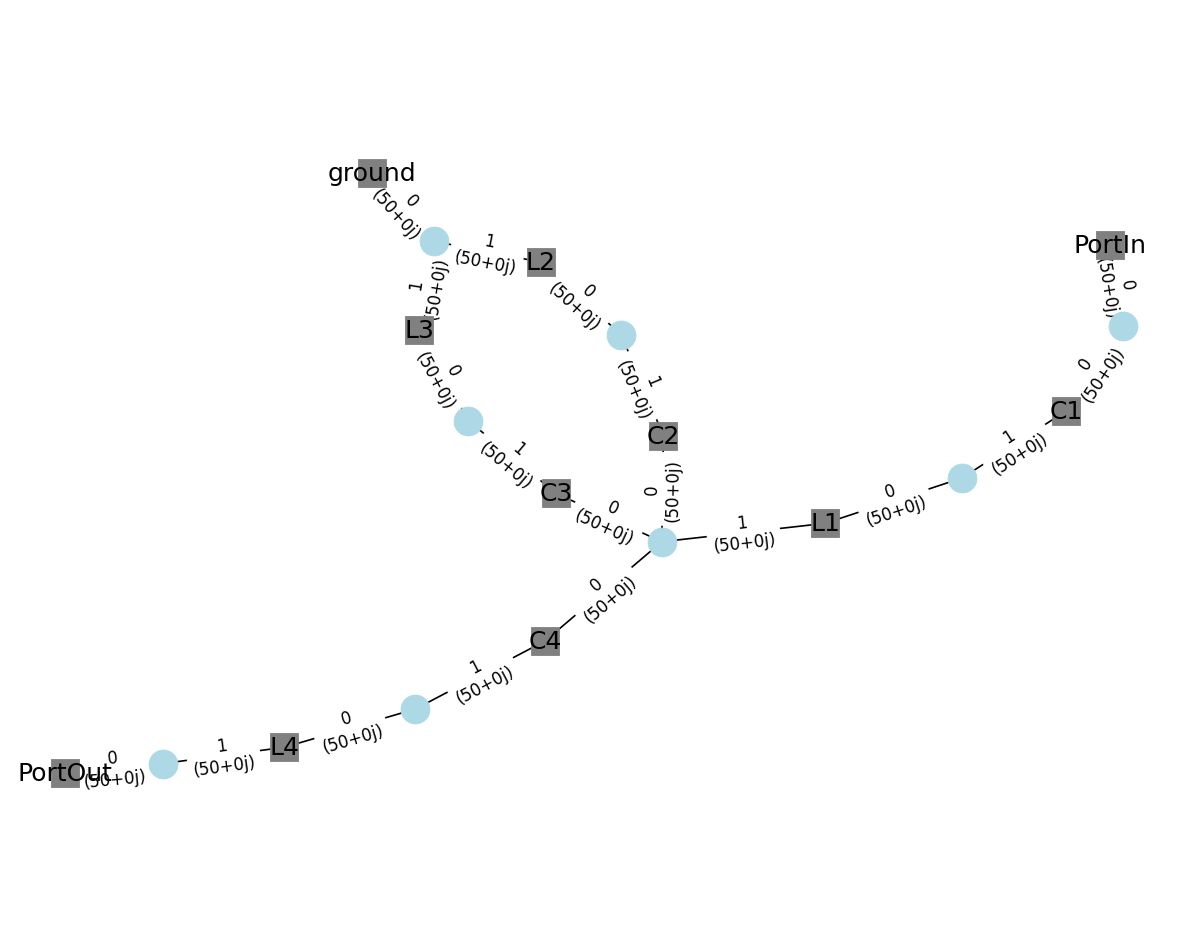

In [16]:
cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
              edge_labels=True, edge_fontsize=10)

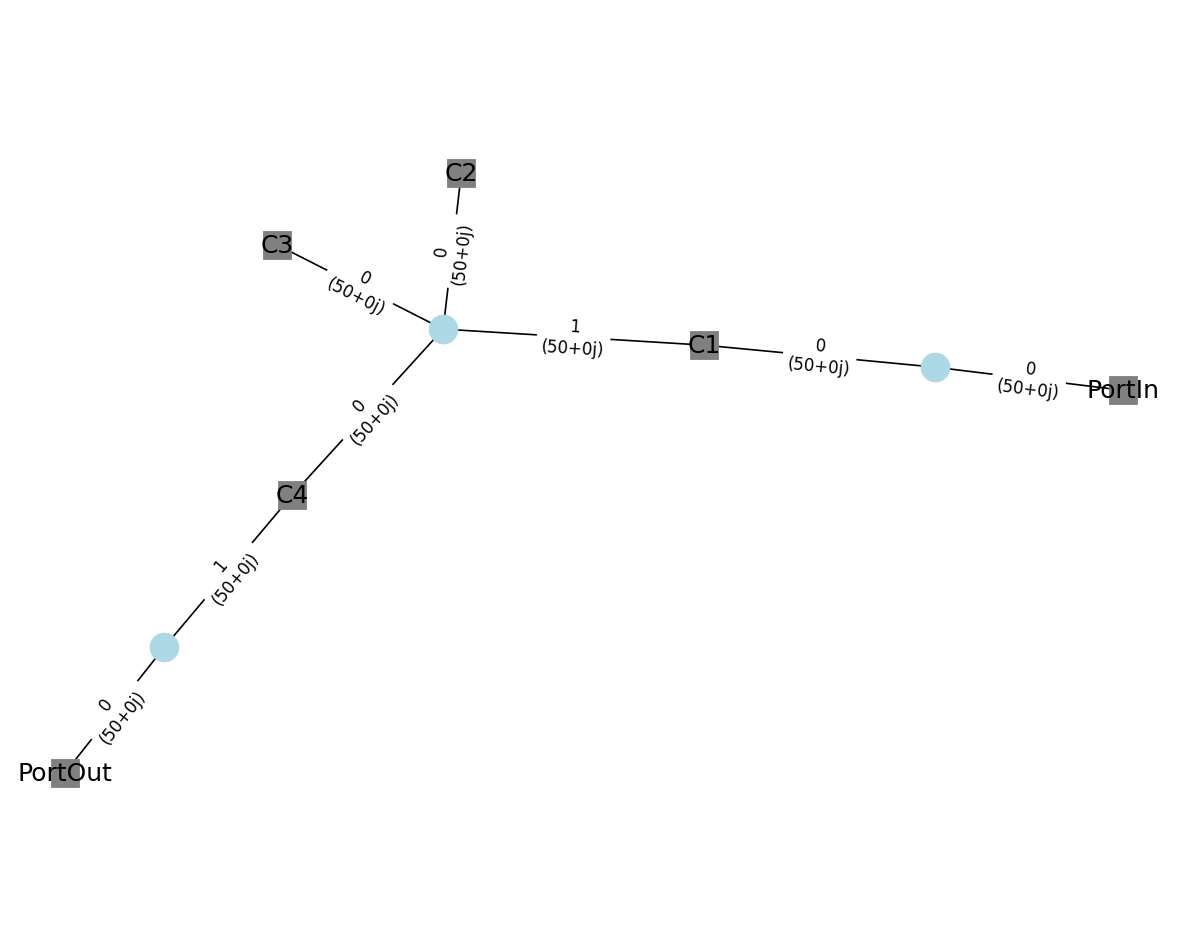

In [17]:
fully_reduced_cnx = rf.reduce_circuit(cnx, split_ground=True)
fully_reduced_cir = rf.Circuit(fully_reduced_cnx)

fully_reduced_cir.plot_graph(network_labels=True, network_fontsize=15,
               port_labels=True, port_fontsize=15,
              edge_labels=True, edge_fontsize=10)

In [19]:
fully_reduced_ntw = fully_reduced_cir.network
auto_reduced_cir = rf.Circuit(cnx, auto_reduce=True)
auto_reduced_ntw = auto_reduced_cir.network
n_times = 10
print(f"Unreduced Circuit calculate Network in {timeit(lambda: cir.network, number=n_times)/n_times:.4f}s")
print(f"Auto-reduced Circuit calculate Network in {timeit(lambda: auto_reduced_cir.network, number=n_times)/n_times:.4f}s")

print(f"Manually reduced circuit has the same s-parameters as the original circuit: {np.allclose(ntw.s, fully_reduced_ntw.s)}")
print(f"Auto reduced circuit has the same s-parameters as the original circuit: {np.allclose(ntw.s, auto_reduced_ntw.s)}")

Unreduced Circuit calculate Network in 0.0089s
Auto-reduced Circuit calculate Network in 0.0013s
Manually reduced circuit has the same s-parameters as the original circuit: True
Auto reduced circuit has the same s-parameters as the original circuit: True
